<h4>Train 25-07</h4>

<p>In this notebook I will futher enhance methodology of the previous notebook</p>

In [1]:
from typing import *
from pathlib import Path
from tqdm import tqdm


import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings("ignore")
np.random.seed(42)


ROOT_DIR = Path(os.getcwd()).parent.parent

<h4>Load calculated features</h4>

In [2]:
df: pd.DataFrame = pd.read_parquet(
    os.path.join(ROOT_DIR, "data/datasets/train_15_08.parquet")
)

df = df.reset_index(drop=True)
# Create pump hash and convert pump time to datetime
df["pump_hash"] = df["pumped_ticker"] + "_" + df["pump_time"]
df["pump_time"] = pd.to_datetime(df["pump_time"])


df["is_pumped"].value_counts()

is_pumped
False    59899
True       469
Name: count, dtype: int64

In [3]:
df = df.replace([np.inf, -np.inf], np.nan)

df.isna().sum().sort_values(ascending=False).head(10)

linear_liquidity_slope_1h            10040
linear_liquidity_slope_6h             1516
log_return_std_6h_30d                  561
linear_liquidity_slope_24h             312
log_return_zscore_6h_30d               199
quote_abs_powerlaw_alpha_1h            185
has_slippage_slope_1d                  172
has_slippage_intercept_1d              172
linear_liquidity_slope_48h             112
quote_slippage_imbalance_ratio_1h       79
dtype: int64

In [4]:
num_cols: List[str] = df.columns[:-8].tolist() + ["days_listed"]
cat_cols: List[str] = ["num_prev_pumps"]

reg_cols: List[str] = num_cols + cat_cols

In [5]:
df[cat_cols] = df[cat_cols].astype("category")

<h4>Fill nans with median value, if is not pumped observation</h4>

<p>If any observation is missing for the pumped ticker, then discard this pump cross-section. Initially we had 353 pumps, after filling in nans using this approach we are left with 337 pumps in the sample.</p>

In [6]:
# skip pump if any variable is missing
df_pumps = pd.DataFrame()

for i, (pump_hash, df_pump) in enumerate(df.groupby("pump_hash")):
    # if any feature is missing for the pump observation, then there is no point to fill it with median value
    if any(df_pump[df_pump["is_pumped"]].isna().any()) or df_pump[df_pump["is_pumped"]].shape[0] == 0:
        continue
    # otherwise fill other cols with median
    for col in num_cols:
        col_median: float = df_pump[col].median()
        df_pump[col] = df_pump[col].fillna(col_median)

    df_pump["pump_id"] = i

    df_pumps = pd.concat([df_pumps, df_pump])

In [7]:
# sort pumps by time
df_pumps = df_pumps.sort_values(by="pump_time", ascending=True).reset_index(drop=True)

In [8]:
df_pumps["is_pumped"].value_counts()

is_pumped
False    53163
True       419
Name: count, dtype: int64

<h4>Cross-section statistics</h4>

<p>In this section, we will graph our cross-sections as well as study distribution of pumps across time</p>

In [23]:
unique_pumps: pd.DataFrame = (
    df_pumps[["pumped_ticker", "pump_time"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .copy()
)

In [10]:
from dataclasses import dataclass
from datetime import timedelta


@dataclass
class Ticker:
    ticker: str
    time: str

    def __post_init__(self):
        self.time: pd.Timestamp = pd.Timestamp(self.time)

    def __str__(self):
        return f"Ticker: {self.ticker} - {str(self.time)}"
    
@dataclass
class PumpEvent(Ticker):
    ticker: str
    time: str
    

pump_events: List[PumpEvent] = []

for idx, pump in unique_pumps.iterrows():
    pump_events.append(
        PumpEvent(ticker=pump.pumped_ticker, time=pump.pump_time)
    )

<p>We will need once again to load tick level data to calculate profits of our strategy as well as other summary statistics like pump volumes and etc.</p>

In [11]:
# load trade data for a given ticker
def load_data(
    ticker: Ticker, lookback_delta: timedelta, 
    forward_delta: timedelta = -timedelta(hours=1) # by default it is set to -1 hours
) -> pd.DataFrame:

    end: pd.Timestamp = ticker.time + forward_delta
    start: pd.Timestamp = ticker.time - lookback_delta

    date_range: List[pd.Timestamp] = pd.date_range(
        start=start, end=end, freq="D", inclusive="both"
    ).tolist()

    df: pd.DataFrame = pd.DataFrame()

    for date in date_range:
        file_name: str = f"{ticker.ticker}-trades-{date.date()}.parquet"
        df_date: pd.DataFrame = pd.read_parquet(
            os.path.join(ROOT_DIR, f"data/trades_parquet/binance/{ticker.ticker}", file_name)
        )
        df = pd.concat([df, df_date])

    df["time"] = pd.to_datetime(df["time"], unit="ms")
    df = df[(df["time"] >= start) & (df["time"] <= end)].reset_index(drop=True)

    df["quote_abs"] = df["price"] * df["qty"] # calculate quote spent

    return df

In [12]:
pump: PumpEvent = pump_events[0]

df_trades: pd.DataFrame = load_data(
    ticker=pump, lookback_delta=timedelta(hours=1), forward_delta=timedelta(hours=1)
)

df_trades["quote_abs"].sum()

508.995266413

In [13]:
# calculate peak time
def calculate_peak_time(df_trades: pd.DataFrame, pump: PumpEvent) -> Optional[float]:
    """Returns number of seconds to the highest price after the pump annoucement"""
    df_trades_post: pd.DataFrame = df_trades[df_trades["time"] >= pump.time].copy()
    
    try:
        pick_time: pd.Timestamp = df_trades_post[
            df_trades_post["price"] == df_trades_post["price"].max()
        ]["time"].iloc[0]
    except IndexError:
        return None

    return (pick_time - pump.time).total_seconds()

In [14]:
# compute volume 1h prior to the pump before and after the annoucement for all pumps
pump: PumpEvent

data = []

for pump in tqdm(pump_events):
    df_trades: pd.DataFrame = load_data(
        ticker=pump, lookback_delta=timedelta(hours=1), forward_delta=timedelta(hours=1)
    )

    data.append({
        # Volumes 
        "prior_volume": df_trades[df_trades["time"] < pump.time]["quote_abs"].sum(),
        "post_volume": df_trades[df_trades["time"] >= pump.time]["quote_abs"].sum(),
        # Time to highest price after the announcement
        "peak_time": calculate_peak_time(df_trades=df_trades, pump=pump)
    })

100%|██████████| 419/419 [00:03<00:00, 115.21it/s]


<h4>Convert volumes to USDT to be able to compare them</h4>

In [15]:
def get_btcusdt(time: pd.Timestamp) -> float:
    """Get BTCUSDT spot for a given time. This is used to convert volumes to USDT"""
    file_name: str = f"BTCUSDT-trades-{time.date()}.parquet"
    df_btc: pd.DataFrame = pd.read_parquet(
        os.path.join(ROOT_DIR, f"data/trades_parquet/binance/BTCUSDT", file_name)
    )
    df_btc["time"] = pd.to_datetime(df_btc["time"], unit="ms") # convert to datetime
    df_btc["time"] = df_btc["time"].dt.tz_localize(None)
    # find closest tick to the given time
    df_btc["time_delta"] = np.abs(df_btc["time"] - time)
    return df_btc[df_btc["time_delta"] == df_btc["time_delta"].min()]["price"].iloc[0]

In [16]:
df_pump_stats: pd.DataFrame = pd.DataFrame(data)
df_pump_stats["pumped_ticker"] = unique_pumps["pumped_ticker"]
df_pump_stats["pump_time"] = unique_pumps["pump_time"]

df_pump_stats = (
    df_pump_stats
    .sort_values(by="pump_time", ascending=True)
    .reset_index(drop=True)
)

df_pump_stats["btcusdt"] = df_pump_stats["pump_time"].apply(get_btcusdt)
df_pump_stats.head(4)

,prior_volume,post_volume,peak_time,pumped_ticker,pump_time,btcusdt
0,3.516777,505.478489,45.322,PPTBTC,2018-01-03 18:00:00,14800.00
1,38.780996,415.869208,73.833,KMDBTC,2018-01-04 16:00:00,14353.01
2,28.802429,1215.337270,31.552,DGDBTC,2018-01-09 20:00:00,14717.82
3,9.294861,1179.143595,69.264,GVTBTC,2018-01-13 20:00:00,14086.64


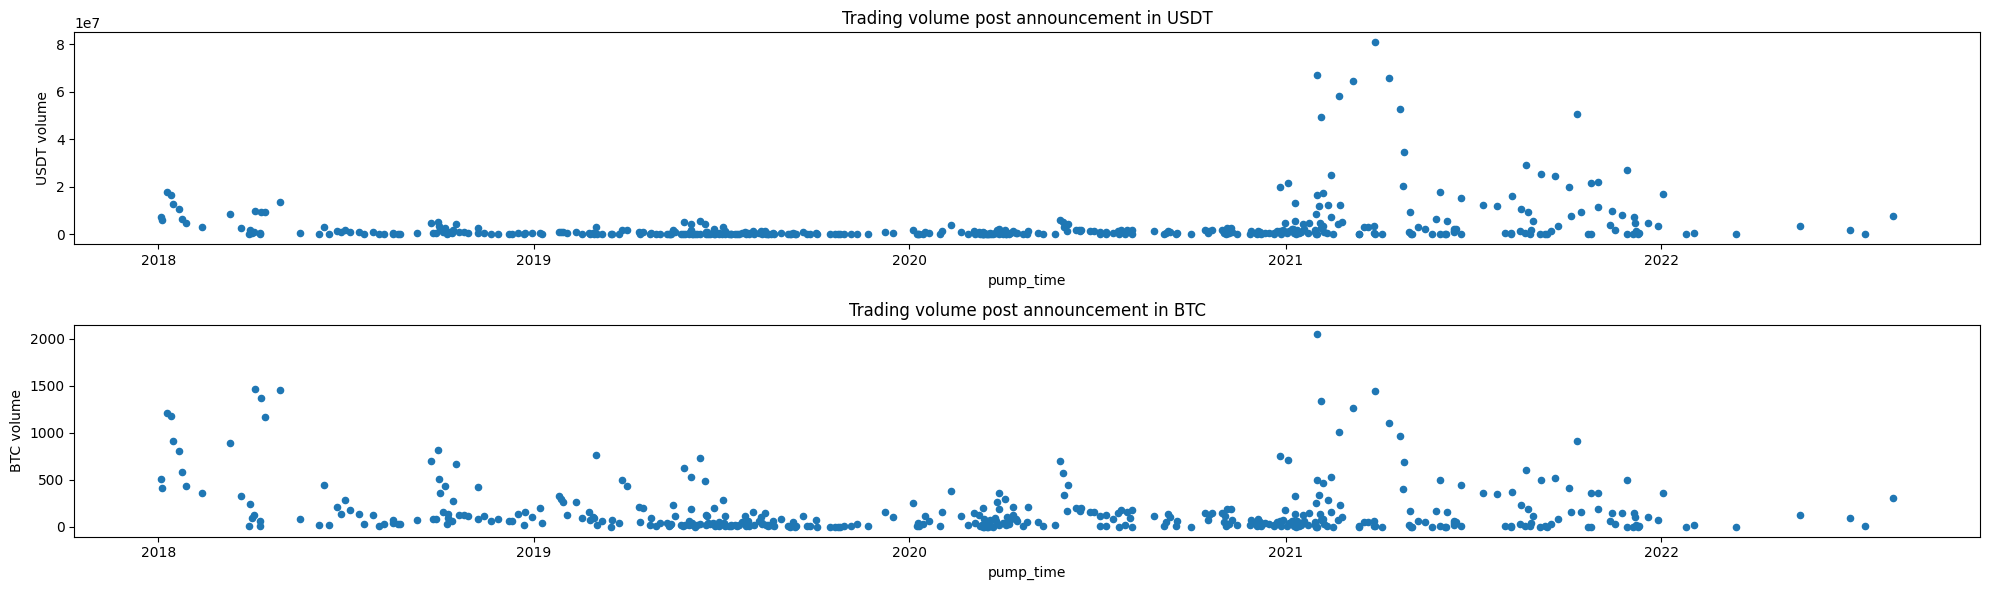

In [17]:
df_pump_stats["prior_volume_usdt"] = df_pump_stats["prior_volume"] * df_pump_stats["btcusdt"]
df_pump_stats["post_volume_usdt"] = df_pump_stats["post_volume"] * df_pump_stats["btcusdt"]

fig, axs = plt.subplots(2, 1, figsize=(20, 6))
ax1, ax2 = axs

df_pump_stats.plot.scatter(x="pump_time", y="post_volume_usdt", ax=ax1)
df_pump_stats.plot.scatter(x="pump_time", y="post_volume", ax=ax2)

ax1.set_title("Trading volume post announcement in USDT")
ax2.set_title("Trading volume post announcement in BTC")
ax1.set_ylabel("USDT volume")
ax2.set_ylabel("BTC volume")

plt.tight_layout()
plt.show()

<h4>Time to peak since annoucement</h4>

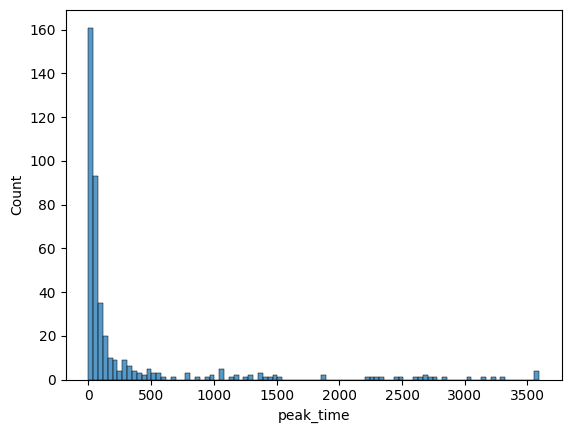

In [18]:
sns.histplot(data=df_pump_stats, x="peak_time")
plt.show()

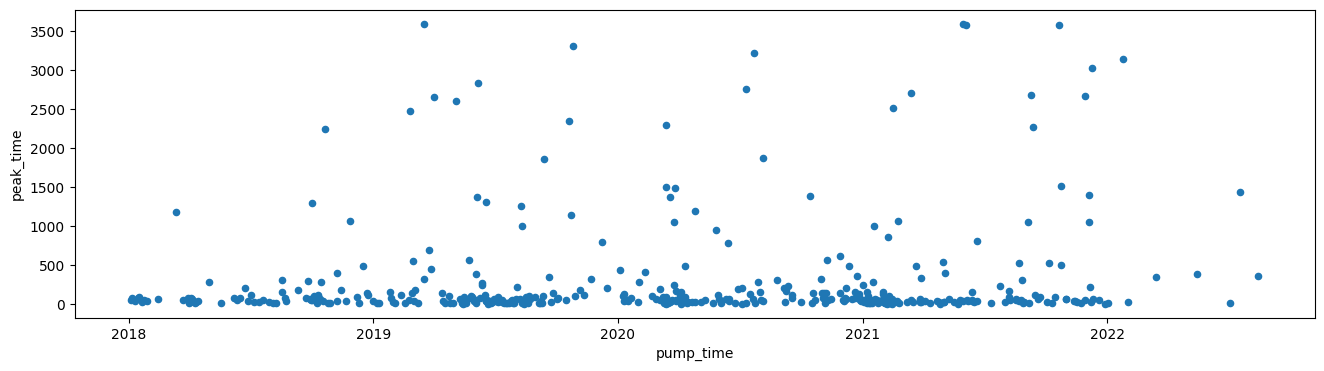

In [19]:
df_pump_stats.plot.scatter(x="pump_time", y="peak_time", figsize=(16, 4))
plt.show()

<h4>Cross-section size in time</h4>

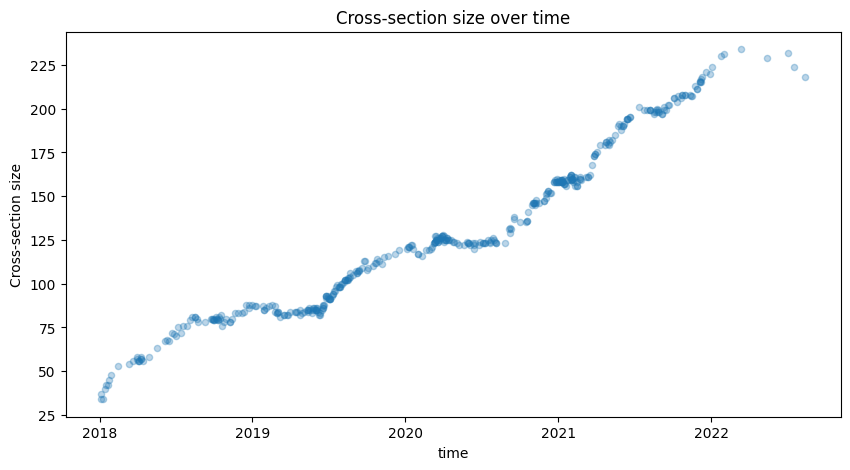

In [20]:
cross_size = []

for (pumped_ticker, pump_time), df_pump in df_pumps.groupby(["pumped_ticker", "pump_time"]):
    cross_size.append({
        "pump_time": pump_time,
        "pumped_ticker": pumped_ticker,
        "crosssection_size": df_pump["ticker"].nunique()
    })

df_cross_size = pd.DataFrame(cross_size)
df_cross_size = df_cross_size.sort_values(by="pump_time", ascending=True).reset_index(drop=True)
df_cross_size.plot.scatter(x="pump_time", y="crosssection_size", alpha=.3, figsize=(10, 5))

plt.title("Cross-section size over time")
plt.ylabel("Cross-section size")
plt.xlabel("time")

# plt.savefig("cross-section_size.png", transparent=True)
plt.show()

<h4>Training of the models</h4>

<p>First we will apply cross-sectional normalization and see how the data looks now</p>

In [21]:
cols_to_scale: List[str] = [
    col for col in df_pumps.columns if (
        ("overall_return" in col) or ("quote_abs_powerlaw" in col)  or ("zscore" in col) or ("linear_liquidity" in col)
    )
]

In [22]:
# Apply cross-sectional standardization
df_scaled: pd.DataFrame = pd.DataFrame()

for pump_hash, df_pump in tqdm(df_pumps.groupby("pump_hash")):
    # Scale each pump by its crosssection
    for col in cols_to_scale:
        df_pump[col] = (df_pump[col] - df_pump[col].mean()) / df_pump[col].std()

    df_scaled = pd.concat([df_scaled, df_pump])

df_scaled.head(2)

100%|██████████| 419/419 [00:03<00:00, 114.98it/s]


,overall_return_1h,volume_quote_abs_zscore_1h_30d,volume_quote_long_share_1h,overall_return_6h,volume_quote_abs_zscore_6h_30d,volume_quote_long_share_6h,log_return_std_6h_30d,log_return_zscore_6h_30d,overall_return_24h,volume_quote_abs_zscore_24h_30d,...,has_slippage_intercept_30d,num_prev_pumps,exchange,pumped_ticker,pump_time,ticker,is_pumped,days_listed,pump_hash,pump_id
41178,-0.040682,-0.422641,0.511676,-0.233731,-0.650415,0.191500,-1.295739,-0.204743,0.130869,-1.038230,...,0.299240,0,binance,ACMBTC,2021-06-05 18:00:13,STRAXBTC,False,199,ACMBTC_2021-06-05 18:00:13,0
41179,-0.213383,-0.196717,0.306216,-0.383051,-0.162977,0.527622,-0.622437,-0.327010,0.066627,-0.240456,...,0.271459,0,binance,ACMBTC,2021-06-05 18:00:13,INJBTC,False,227,ACMBTC_2021-06-05 18:00:13,0


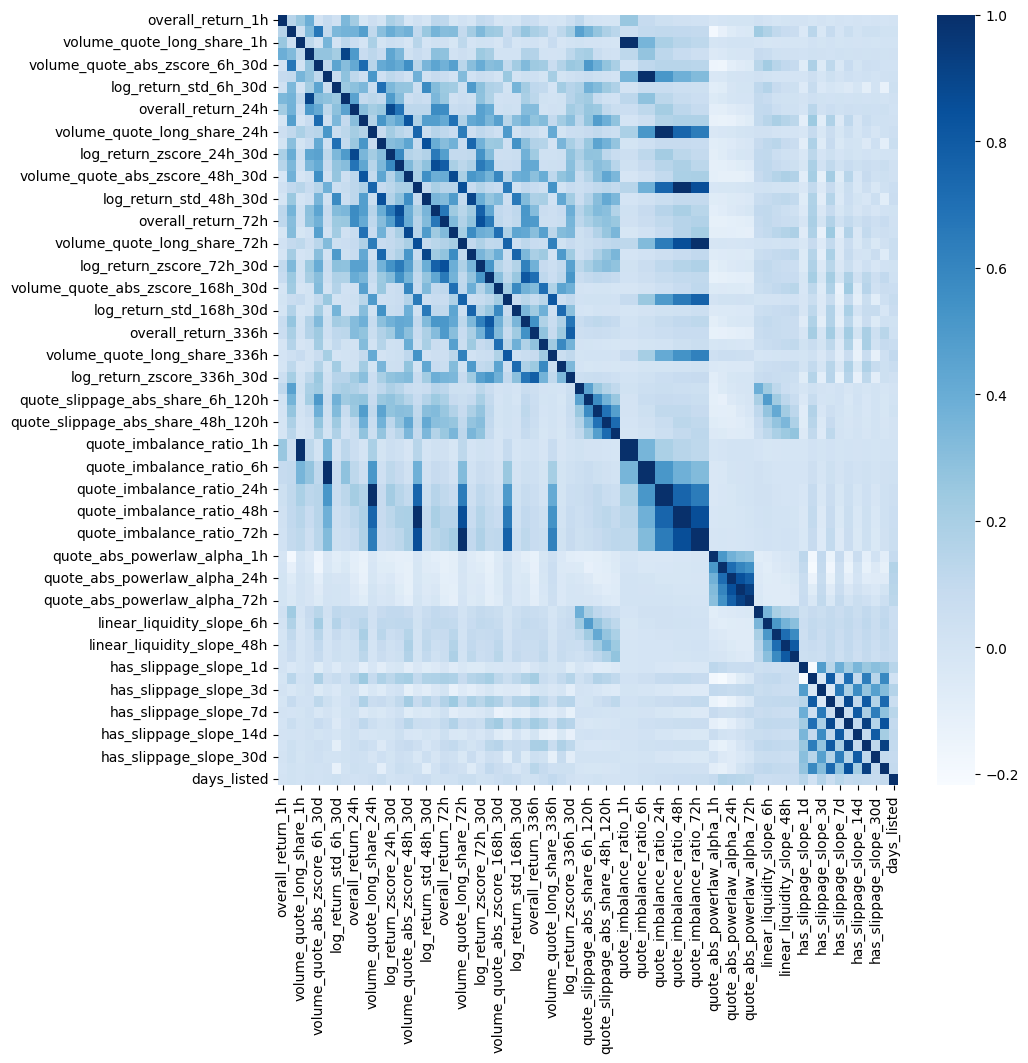

In [24]:
plt.figure(figsize=(10, 10))

sns.heatmap(data=df_scaled[num_cols].corr(), cmap="Blues")
plt.show()

<h4>Plot data with cross-norm and without cross-norm side by side</h4>

100%|██████████| 3/3 [00:00<00:00,  4.75it/s]


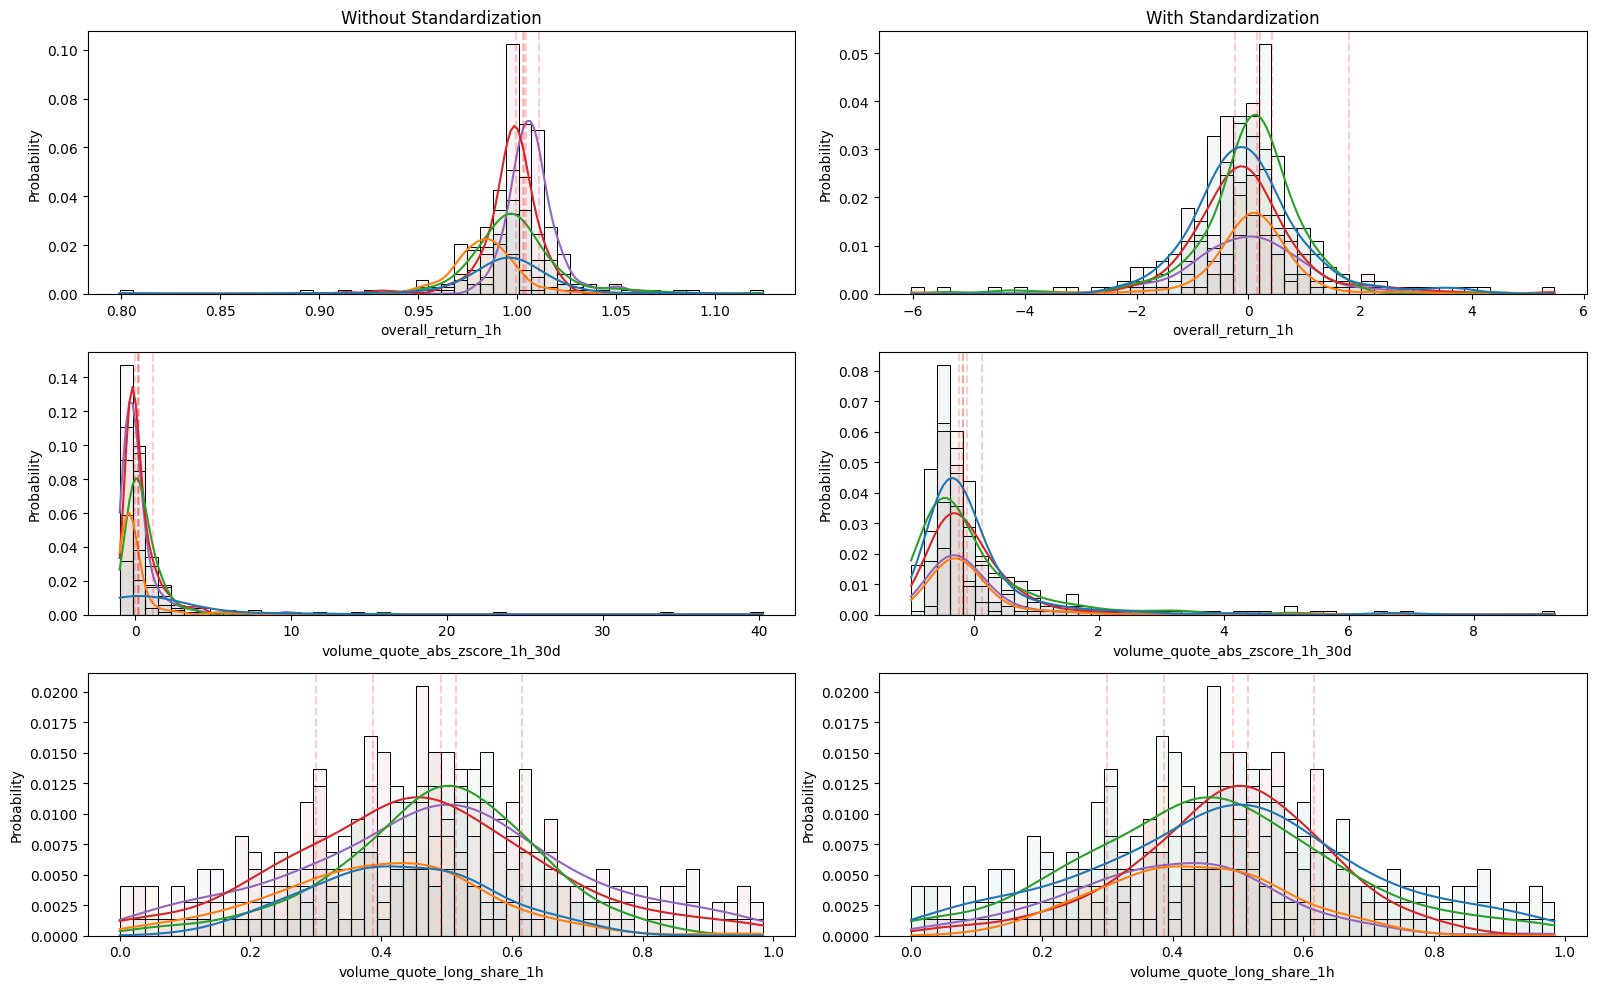

In [29]:
pumps_plot: np.array = np.random.choice(df_pumps["pump_hash"].unique(), 5, replace=False) # choose 5 random pumps to plot

df_plot: pd.DataFrame = df_pumps[df_pumps["pump_hash"].isin(pumps_plot)].copy()
df_plot_scaled: pd.DataFrame = df_scaled[df_scaled["pump_hash"].isin(pumps_plot)].copy()

cols_to_plot = num_cols[:3]

fig, axs = plt.subplots(3, 2, figsize=(16, 10))

for col, (ax1, ax2) in tqdm(zip(cols_to_plot, axs), total=3):

    # Plot not scaled and scaled hists
    sns.histplot(
        data=df_plot, x=col, hue="pump_hash", ax=ax1, 
        legend=False, alpha=.05, bins=50, kde=True, stat="probability"
        )
    sns.histplot(
        data=df_plot_scaled, x=col, hue="pump_hash", ax=ax2, 
        legend=False, alpha=.05, bins=50, kde=True, stat="probability"
    )

    for pump_hash in pumps_plot:
        pumped_ticker: pd.Series = (
            (df_plot["pump_hash"] == pump_hash) & (df_plot["is_pumped"])
        )
        pumped_ticker_scaled: pd.Series = (
            (df_plot_scaled["pump_hash"] == pump_hash) & (df_plot_scaled["is_pumped"])
        )

        ax1.axvline(x=df_plot[pumped_ticker][col].iloc[-1], color="red", linestyle="--", alpha=.2)
        ax2.axvline(x=df_plot_scaled[pumped_ticker_scaled][col].iloc[-1], color="red", linestyle="--", alpha=.2)

for ax, col in zip(axs[0], ["Without Standardization", "With Standardization"]):
    ax.set_title(col)


plt.tight_layout()
plt.savefig("features_with_without_norm.png", transparent=True)
plt.show()

In [ ]:
def compute_return(ticker: Ticker) -> float:
    """Calculates return of the ticker around some pump.time"""
    try:
        df_asset: pd.DataFrame = load_data(
            ticker=ticker, lookback_delta=timedelta(hours=1), forward_delta=timedelta(hours=1)
        )
    except FileNotFoundError:
        return 0

    df_asset: pd.DataFrame = df_asset[
        (df_asset["time"] >= ticker.time - timedelta(minutes=1)) &
        (df_asset["time"] <= ticker.time + timedelta(minutes=1))
    ].copy()

    if df_asset.empty:
        return 0

    start_price, end_price = df_asset["price"].iloc[0], df_asset["price"].iloc[-1]
    asset_return: float = (end_price - start_price) / start_price

    return asset_return

In [ ]:
df_returns: pd.DataFrame = pd.DataFrame()

for (pumped_ticker, pump_time), df_pump in tqdm(df_scaled.groupby(["pumped_ticker", "pump_time"])):

    tickers_crosssection: List[str] = df_pump["ticker"].tolist()
    asset_returns: List[float] = []

    for ticker in tickers_crosssection:
        ticker_obj: Ticker = Ticker(ticker=ticker, time=pump_time)
        asset_returns.append(
            compute_return(ticker=ticker_obj)
        )
    
    df_pump["asset_return"] = asset_returns
    df_returns = pd.concat([df_returns, df_pump])

In [ ]:
df_returns["pump_id"].nunique()

In [ ]:
df_returns["asset_return_rank"] = df_returns.groupby("pump_id")["asset_return"].rank(ascending=False)

In [ ]:
df_filtered_returns: pd.DataFrame = pd.DataFrame()

for pump_id, df_pump in tqdm(df_returns.groupby("pump_id")):
    if df_pump[df_pump["is_pumped"]]["asset_return_rank"].iloc[0] <= 10:
        df_filtered_returns = pd.concat([df_filtered_returns, df_pump])


df_filtered_returns["is_pumped"].value_counts()

<h4>Train-test split</h4>

In [ ]:
df_train, df_test = (
    df_scaled[df_scaled["pump_time"] <= "2021-05-10"].copy(),  # train sample
    df_scaled[df_scaled["pump_time"] > "2021-05-10"].copy(),  # test sample
)

df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)

pumps: List[int] = [
    df_train["is_pumped"].sum(),
    df_test["is_pumped"].sum()
]

pd.DataFrame({
    "sample": ["train", "test"],
    "num_pumps": pumps
})

<h4>Filter out failed pumps based on returns</h4>

In [ ]:
df_train["is_pumped"].value_counts()

<h4>Baseline Logistic Regression</h4>

In [ ]:
# on average the size of crosssection
mean_crosssection_size: float = df_scaled.groupby("pump_hash")["ticker"].count().mean()
mean_crosssection_size

In [ ]:
from sklearn.linear_model import LogisticRegression


# Train baseline Logistic Regression 
model_lr = LogisticRegression(
    max_iter=int(1e10),
    class_weight={0: 1, 1: mean_crosssection_size},
)

model_lr.fit(df_train[reg_cols], df_train["is_pumped"])

probas_pred_lr = model_lr.predict_proba(df_test[reg_cols])[:, 1]

<h4>Plot Precision Recall Curve and compute PRAUC on validation sample</h4>

In [ ]:
from sklearn.metrics import precision_recall_curve, auc, PrecisionRecallDisplay


def plot_precision_recall(
    df: pd.DataFrame, model_probas: Dict[str, np.array], figsize: Tuple[int, int] = (10, 10)
) -> None:
    """Plot Precision Recall curve for the model"""
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    for model_name, y_proba in model_probas.items():
        precision, recall, _ = precision_recall_curve(
            y_true=df["is_pumped"], probas_pred=y_proba
        )
        PrecisionRecallDisplay(precision=precision, recall=recall).plot(
            ax=ax, label=f"PRAUC: {model_name} - {auc(recall, precision):.4f}"
        )

    f_scores = np.linspace(0.1, 0.8, num=10)

    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = ax.plot(x[y >= 0], y[y >= 0], color="blue", alpha=0.2)
        ax.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    plt.legend(loc="upper right")
    plt.title("Precision Recall curves")


plot_precision_recall(
    df=df_test, model_probas={
        "LogisticRegression": probas_pred_lr
    }
)

<h4>L1 regulirization</h4>

In [ ]:
from sklearn.metrics import log_loss


def train_logistic_regression(lambda_val: float) -> Dict[str, float]:
    """Train Logistic Regression model given a l1 lambda value"""
    model = LogisticRegression(
        class_weight="balanced",
        max_iter=10000,
        penalty="l1",
        solver="liblinear", n_jobs=-1, C=1/lambda_val
    )

    model = model.fit(df_train[reg_cols], df_train["is_pumped"])
    # Metrics on train set
    probas_pred = model.predict_proba(df_train[reg_cols])
    loss: float = log_loss(
        y_true=df_train["is_pumped"], y_pred=probas_pred
    )
    # PR-AUC
    precision, recall, _ = precision_recall_curve(y_true=df_train["is_pumped"], probas_pred=probas_pred[:, 1])
    prauc_score: float = auc(x=recall, y=precision)

    return {
        "lambda_val": lambda_val,
        "coef": model.coef_[0],
        "logloss": loss,
        "prauc": prauc_score
    }


log_res: List[Dict[str, Any]] = []
lambda_vals: np.ndarray[int] = np.logspace(0, 4, 50)

# Train multiple models with different strength of L1-regulirization
for lambda_val in tqdm(lambda_vals):
    log_res.append(
        train_logistic_regression(lambda_val=lambda_val)
    )

<h4>Plot metrics over different values of L1-reg lambda</h4>

In [ ]:
df_l1 = pd.DataFrame(log_res).explode("coef")

data = []

for lambda_val, df_lambda in df_l1.groupby("lambda_val"):
    data.append({
        "lambda_val": lambda_val,
        "num_nonzero_coefs": df_lambda[df_lambda["coef"] != 0].shape[0],
        "logloss": df_lambda["logloss"].iloc[0],
        "prauc": df_lambda["prauc"].iloc[0]
    })

fig, ax = plt.subplots(2, 2, figsize=(16, 7))
ax1, ax2, ax3, _ = ax.flatten()

df_data = pd.DataFrame(data)
df_data.plot(x="lambda_val", y="num_nonzero_coefs", ax=ax1)
df_data.plot(x="lambda_val", y="logloss", ax=ax2)
df_data.plot(x="lambda_val", y="prauc", ax=ax3)

ax1.set_title("Number of non-zero coefficients")
ax1.set_xlabel("$\lambda$")
ax1.set_xscale("log")
ax1.set_ylabel("Number of non-zero coefficients")

ax2.set_title("Logloss")
ax2.set_xlabel("$\lambda$")
ax2.set_ylabel("Train logloss")
ax2.set_xscale("log")

ax3.set_title("Train PR-AUC")
ax3.set_xlabel("$\lambda$")
ax3.set_xscale("log")

plt.tight_layout()
plt.show()

<h4>Obtain set of features given each value of L1 regulirization lambda</h4>

In [ ]:
log_res = []

for lambda_val in [1, 10, 100, 1000]:
    log_res.append({
        "lambda_val": lambda_val,
        **train_logistic_regression(lambda_val=lambda_val)
    })

df_coefs: pd.DataFrame = pd.DataFrame(log_res).explode("coef")
df_coefs["feature"] = reg_cols * 4

In [ ]:
plt.figure(figsize=(16, 12))

df_plot = df_coefs.copy()
df_plot = df_plot.sort_values(by="coef", ascending=False, key=abs)

sns.barplot(
    data=df_plot, x="coef", y="feature", hue="lambda_val", palette=["blue", "grey", "lightblue", "red"]
)

plt.title("Logistic Regression coefficients / FI given different L1 lambda")
plt.tight_layout()

In [ ]:
l1_features: Dict[int, List[str]] = {}

for lambda_val, df_lambda in df_coefs.groupby("lambda_val"):
    l1_features[lambda_val] = df_lambda[df_lambda["coef"] != 0]["feature"].tolist()

In [ ]:
[len(features) for features in l1_features.values()]

<h4>Calculate model profitability on the test sample</h4>

<ol>
    <li>We make a prediction based on data we have and obtain logits for the current cross-section</li>
    <li>We create a portfolio weighted by logits or some other weighting and buy it after prediction. This implies that we buy up to 1 hour prior to the pump</li>
    <li>We hold the portfolio until some condition is met, pumped asset reached a certain required return (like 30%) or some time since the pump has passed</li>
    <li>After all of this we calculate the return of such portfolio</li>
</ol>


In [ ]:
# features were computed up to rounded time - timedelta(hours=1)
pump.time.round("1h") - timedelta(hours=1)

In [ ]:
from abc import ABC, abstractmethod
from dataclasses import asdict


@dataclass
class Portfolio:

    tickers: List[str]
    weights: np.ndarray[float]

    def __repr__(self) -> str:
        return f"Portfolio: {dict(zip(self.tickers, self.weights.round(4)))}"
    
    def get_weight(self, ticker: str) -> float:
        """Return weight of the asset in the portfolio"""
        return self.weights[self.tickers.index(ticker)]
    

@dataclass
class Transaction:
    ticker: str
    buy_price: float
    sell_price: float
    buy_ts: pd.Timestamp
    sell_ts: pd.Timestamp

    def to_dict(self):
        return {k: str(v) for k, v in asdict(self).items()}


class PortfolioTester(ABC):

    def __init__(self, model):
        self.model = model
        self.log: pd.DataFrame = pd.DataFrame()

    @abstractmethod
    def create_portfolio(self, df_probas: pd.DataFrame, pump: PumpEvent) -> Portfolio:
        """Returns a dict of portfolio weights"""

    @abstractmethod
    def sell_portfolio(self, portfolio: Portfolio, pump: PumpEvent) -> List[Transaction]:
        """returns pd.DataFrame of transactions. In this method describe all entries and exit prices"""

    def calculate_portfolio_return(self, transactions: List[Transaction], portfolio: Portfolio) -> float:
        """
            transactions = [
                Transaction(ticker="ADABTC", buy_price=0.004, sell_price=0.005, buy_ts=buy_ts, sell_ts=sell_ts}
            ]
        """
        portfolio_return: float = 0
        transaction: Transaction

        for transaction in transactions:
            asset_return = (transaction.sell_price - transaction.buy_price) / transaction.buy_price
            portfolio_return += asset_return * portfolio.get_weight(transaction.ticker)

        return portfolio_return
    
    def load_data(self, ticker: str, pivot_ts: pd.Timestamp, lookback_delta: timedelta, forward_delta: timedelta) -> pd.DataFrame:
        """Load ticke level data from local storage"""
        start: pd.Timestamp = pivot_ts - lookback_delta
        end: pd.Timestamp = pivot_ts + forward_delta

        date_range: List[pd.Timestamp] = pd.date_range(start=start, end=end, freq="D", inclusive="both").tolist()
        df: pd.DataFrame = pd.DataFrame()

        for date in date_range:
            file_name: str = f"{ticker}-trades-{date.date()}.parquet"
            df_date: pd.DataFrame = pd.read_parquet(
                os.path.join(ROOT_DIR, f"data/trades_parquet/binance/{ticker}", file_name)
            )
            df = pd.concat([df, df_date])

        df["time"] = pd.to_datetime(df["time"], unit="ms")
        df = df[(df["time"] >= start) & (df["time"] <= end)].reset_index(drop=True)
        df["quote_abs"] = df["price"] * df["qty"] # calculate quote spent

        return df
    

    def get_buy_price(self, df_ticker: pd.DataFrame, buy_ts: pd.Timestamp) -> float:
        """Get the price closest to buy_ts timestamp and return the corresponding price"""
        df_ticker["ts_delta"] = np.abs(df_ticker["time"] - buy_ts)
        # find minimum abs difference in time to get the closest price
        buy_price: float = df_ticker[df_ticker["ts_delta"] == df_ticker["ts_delta"].min()]["price"].iloc[0]
        return buy_price
    

    def get_sell_price(self, df_ticker: pd.DataFrame, pump: PumpEvent) -> Tuple[float, pd.Timestamp]:
        """
        Get the sell price closest to sell_ts which is essentially pump.time. This method is called for assets that were misclassified
        by the model which are immediately sold at pump.time
        """
        df_ticker["ts_delta"] = np.abs(df_ticker["time"] - pump.time)
        # find minimum abs difference in time to get the closest price
        sell_price: float = df_ticker[df_ticker["ts_delta"] == df_ticker["ts_delta"].min()]["price"].iloc[0]
        return sell_price, pump.time
    
    
    def log_transactions(self, portfolio: Portfolio, transactions: List[Transaction], pump: PumpEvent) -> None:
        """Save log of transactions to the df_log_transactions"""
        transaction: Transaction

        df_log: pd.DataFrame = pd.DataFrame.from_dict([transaction.to_dict() for transaction in transactions])
        df_log["weight"] = portfolio.weights
        df_log["pumped_ticker"] = pump.ticker
        df_log["pump_time"] = pump.time

        self.log = pd.concat([self.log, df_log])
        

    def evaluate_crosssection(self, df_crosssection: pd.DataFrame, reg_cols: List[str], pump: PumpEvent) -> Dict[str, Any]:
        """
        1. Make a prediction using self.model.predict_proba and then take top logits to create a portfolio
        2. Create a portfolio using self.create_portfolio method 
        3. Sell portfolio using self.sell_portfolio method
        """
        probas_pred: np.array = self.model.predict_proba(df_crosssection[reg_cols])[:, 1] # take probas of the minority class
        # Create a dataset with probas and tickers
        df_probas: pd.DataFrame = pd.DataFrame({
            "ticker": df_crosssection["ticker"],
            "proba": probas_pred
        })

        portfolio: Portfolio = self.create_portfolio(df_probas=df_probas, pump=pump)
        transactions: List[Transaction] = self.sell_portfolio(portfolio=portfolio, pump=pump)
        portfolio_return: float = self.calculate_portfolio_return(transactions=transactions, portfolio=portfolio)

        # Add all transactions to log
        self.log_transactions(portfolio=portfolio, transactions=transactions, pump=pump)

        return {
            "portfolio_return": portfolio_return,
            "portfolio_contained_pump": pump.ticker in portfolio.tickers
        }
    
    def backtest(self, df_test: pd.DataFrame, reg_cols: List[str]) -> pd.DataFrame:
        """Calculates returns for each cross-section in df_test sample and returns stats on the strategy returns"""
        
        portfolio_outputs: List[Dict[str, Any]] = []
        self.log: pd.DataFrame = pd.DataFrame() # clear log on restart

        for (pumped_ticker, pump_time), df_crosssection in tqdm(df_test.groupby(["pumped_ticker", "pump_time"])):
            try:
                pump: PumpEvent = PumpEvent(ticker=pumped_ticker, time=pump_time)
                portfolio_output: Dict[str, Any] = self.evaluate_crosssection(
                    df_crosssection=df_crosssection, reg_cols=reg_cols, pump=pump
                )
                portfolio_outputs.append({
                    **portfolio_output,
                    "pumped_ticker": pumped_ticker,
                    "pump_time": pump_time,
                })
            except FileNotFoundError:
                continue
        
        df_backtest: pd.DataFrame = pd.DataFrame(portfolio_outputs)
        df_backtest = df_backtest.sort_values(by="pump_time", ascending=True).reset_index(drop=True)
        return df_backtest

In [ ]:
class TOPKPortfolio(PortfolioTester):


    def __init__(self, model, use_k: int):
        self.use_k: int = use_k # K assets to use in the portfolio
        super().__init__(model)


    def create_portfolio(self, df_probas: pd.DataFrame, pump: PumpEvent) -> Portfolio:
        """Create portfolio using some K as the number of assets"""
        df_probas = df_probas.sort_values(by="proba", ascending=False).reset_index(drop=True)
        df_portfolio: pd.DataFrame = df_probas[:self.use_k].copy() # select the TOP-5 highest probas

        # create weights proportional to probas
        df_portfolio["weight"] = [1 / self.use_k] * self.use_k

        return Portfolio(
            tickers=df_portfolio["ticker"].tolist(),
            weights=df_portfolio["weight"].to_numpy()
        )
    

    def get_sell_price_pumped(self, buy_price: float, df_ticker: pd.DataFrame, pump: PumpEvent) -> Tuple[float, pd.Timestamp]:
        """
        This method is called to calculate the sell price of the pumped asset which we have in the portfolio. We might want to hold
        this asset for longer to achieve some required level of return or reach the hold period.
        """

        sell_ts: pd.Timestamp = pump.time + timedelta(minutes=1)

        # sell_ts is defined 
        df_ticker["ts_delta"] = np.abs(df_ticker["time"] - sell_ts)
        # find minimum abs difference in time to get the closest price
        sell_price: float = df_ticker[df_ticker["ts_delta"] == df_ticker["ts_delta"].min()]["price"].iloc[0]

        return sell_price, sell_ts
    

    def sell_portfolio(self, portfolio: Portfolio, pump: PumpEvent) -> List[Transaction]:

        transactions: List[Transaction] = []

        for ticker in portfolio.tickers:
            # Load tick data for the ticker 2 hours before and after the pump event
            df_ticker: pd.DataFrame = self.load_data(
                ticker=ticker, pivot_ts=pump.time, lookback_delta=timedelta(hours=2), forward_delta=timedelta(hours=2)
            )
            # Find entry price (we buy pump.time.round("hour") - timedelta(hours=1))
            buy_ts: pd.Timestamp = pump.time - timedelta(minutes=5)
            buy_price: float = self.get_buy_price(df_ticker=df_ticker, buy_ts=buy_ts) # find buy price for this ticker

            # Find sell price. If the asset is not pumped, then we sell at the price at pump.time otherwise we 
            # hold the asset some time and sell it later.

            sell_price: float
            sell_ts: pd.Timestamp

            sell_price, sell_ts = (
                self.get_sell_price(df_ticker=df_ticker, pump=pump) if ticker != pump.ticker else # get regular sell price
                self.get_sell_price_pumped(buy_price=buy_price, df_ticker=df_ticker, pump=pump) # get price for the pumped asset
            )
            # Create a transaction and append to the list
            transactions.append(
                Transaction(ticker=ticker, buy_price=buy_price, sell_price=sell_price, buy_ts=buy_ts, sell_ts=sell_ts)
            )

        return transactions

In [ ]:
topk_manager = TOPKPortfolio(model=model_lr, use_k=5)
df_returns = topk_manager.backtest(df_test=df_test, reg_cols=reg_cols)
df_returns.head(5)

In [ ]:
sns.histplot(data=df_returns, hue="portfolio_contained_pump", x="portfolio_return", bins=10)
plt.show()

In [ ]:
# get transactions history
topk_manager.log.head(5)

<h4>Distribution of returns for Logistic Regression for some values of K for TOP-K portfolios</h4>

In [ ]:
topk_bins: List[int] = [1, 3, 5, 10]
df_topk_returns: pd.DataFrame = pd.DataFrame()

for K in topk_bins:
    topk_manager = TOPKPortfolio(model=model_lr, use_k=K)
    df_returns: pd.DataFrame = topk_manager.backtest(df_test=df_test, reg_cols=reg_cols)
    df_returns["K"] = K

    df_topk_returns = pd.concat([df_topk_returns, df_returns])

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

for K, df_returns in df_topk_returns.groupby("K"):
    df_returns["cumulative_portfolio_return"] = df_returns["portfolio_return"].cumsum()
    df_returns.plot(x="pump_time", y="cumulative_portfolio_return", ax=ax, label=f"TOP-{K}")

In [ ]:
df_topk_returns.groupby("K")["portfolio_return"].agg(["min", "mean", "std", "max"])

<h4>TOP-K% portfolios</h4>

In [ ]:
class TOPKPPortfolio(TOPKPortfolio):
    
    def __init__(self, model, use_k: float):
        # In this case use_k is a percentage between (0, 1)
        super().__init__(model, use_k) 

    # Only redefine create_portfolio method, the rest is the same
    def create_portfolio(self, df_probas: pd.DataFrame, pump: PumpEvent) -> Portfolio:
        """Create portfolio using some K as the number of assets"""
        df_probas = df_probas.sort_values(by="proba", ascending=False).reset_index(drop=True)
        # Create crosssection percentages
        df_probas["share"] = (df_probas.index + 1) / df_probas.shape[0]

        df_portfolio: pd.DataFrame = df_probas[df_probas["share"] <= self.use_k].copy()
        n_assets = df_portfolio.shape[0]
        
        df_portfolio["weight"] = [1 / n_assets] * n_assets

        return Portfolio(
            tickers=df_portfolio["ticker"].tolist(),
            weights=df_portfolio["weight"].to_numpy()
        )

In [ ]:
topkp_manager = TOPKPPortfolio(model=model_lr, use_k=0.1)
df_returns: pd.DataFrame = topkp_manager.backtest(df_test=df_test, reg_cols=reg_cols)

<h4>Distribution of returns for Logistic Regression for some values of K% for TOP-K% portfolios</h4>

In [ ]:
topk_shares: List[float] = [0.01, 0.03, 0.05, 0.1, 0.2, 0.3]
df_topkp_returns: pd.DataFrame = pd.DataFrame()

for KP in topk_shares:
    topkp_manager = TOPKPPortfolio(model=model_lr, use_k=KP)
    df_returns: pd.DataFrame = topkp_manager.backtest(df_test=df_test, reg_cols=reg_cols)
    df_returns["KP"] = KP

    df_topkp_returns = pd.concat([df_topkp_returns, df_returns])

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

for KP, df_returns in df_topkp_returns.groupby("KP"):
    df_returns["cumulative_portfolio_return"] = df_returns["portfolio_return"].cumsum()
    df_returns.plot(x="pump_time", y="cumulative_portfolio_return", ax=ax, label=f"TOP-{int(KP*100)}%")

In [ ]:
df_topkp_returns.groupby("KP")["portfolio_return"].agg(["min", "mean", "std", "max"])

<h4>Metrics used for tuning</h4>

<h4>TOP-K accuracy or Hit Ratio K</h4>

In [ ]:
def calculate_topk(
    df_test: pd.DataFrame, probas_pred: np.array, topk_bins: List[int]
) -> Dict[int, float]:
    """Compute top-k accuracy of the model using validation sample"""

    topk_vals = []
    df_test["probas_pred"] = probas_pred

    for K in topk_bins: 

        topk: List[bool] = []

        for _, df_test_pump in df_test.groupby("pump_hash"):
            df_test_pump: pd.DataFrame = df_test_pump.sort_values(by="probas_pred", ascending=False) # sort tickers by logits 
            topk_contains_pump: bool = df_test_pump.iloc[:K]["is_pumped"].any() # see if any of the top k logits has label is_pumped == 1
            topk.append(topk_contains_pump) 
            
        topk_vals.append(
            sum(topk) / len(topk) # probability of having true label in top-k logits
        )
            
    return dict(zip(topk_bins, topk_vals))

In [ ]:
topk_bins: List[int] = [1, 3, 5, 10, 20, 30]

topk: Dict[int, float] = calculate_topk(df_test=df_test, probas_pred=probas_pred_lr, topk_bins=topk_bins)

df_topk = pd.DataFrame({
    "K": topk.keys(),
    "HR@K": topk.values()
})

df_topk

<h4>We would like to have a metric taking into account top-k performance for all Ks</h4>


$$\text{Avg} \hspace{0.25em} \frac{\partial{\text{TOP-K}}}{\partial{K}} \approx \frac{1}{|K|} \sum_{k \in K} \frac{\Delta \text{TOP-k}}{\Delta k} \hspace{1em} \text{where} \hspace{0.25em} K = \{1, 3, 5, 10, 20, 30\}$$

In [ ]:
# We would like to maximize returns on increasing K

def calculate_mean_topk_derivative(
    df: pd.DataFrame, probas_pred: np.array, topk_bins: List[int]
) -> float:
    """Calculates average mean increase in TOP-K as K increases"""
    topk: Dict[int, float] = calculate_topk(df=df, probas_pred=probas_pred, topk_bins=topk_bins)

    df_topk = pd.DataFrame({
        "K": topk.keys(),
        "HR@K": topk.values()
    })

    return np.mean(
        df_topk["HR@K"].diff() / df_topk["K"].diff()
    )

<h4>TOP-K%</h4>

All cross-sections are of different sizes therefore it will be better to use TOP-K% instead of just K. This metric shows the probability of having a true label withing K% of the alternatives

In [ ]:
def calculate_topk_percent(
    df: pd.DataFrame, probas_pred: np.array, topk_share_bins: np.array
) -> Dict[float, float]:
    """Calculates TOP-K% for a given model and ground truth stored in df"""

    dfc: pd.DataFrame = df.copy()
    dfc["probas_pred"] = probas_pred

    topk_vals: Dict[float, List[float]] = {K: [] for K in topk_share_bins}

    for _, df_pump in dfc.groupby("pump_hash"):
        df_pump: pd.DataFrame = df_pump.sort_values(by="probas_pred", ascending=False) # sort tickers by logits 
        # calculate percentages 
        df_pump = df_pump.reset_index(drop=True) # reset index based off which we will compute percentage
        df_pump["percentage"] = (df_pump.index + 1) / df_pump.shape[0]

        for K in topk_share_bins:
            # leave observations below K% of the cross-section
            df_pump_portfolio: pd.DataFrame = df_pump[df_pump["percentage"] <= K].copy()
            topk_contains_pump: bool = df_pump_portfolio["is_pumped"].any() # see if any of the top k% logits has label is_pumped == 1
            topk_vals[K].append(topk_contains_pump)

    return {K: np.mean(topk_vals[K]) for K in topk_share_bins}


calculate_topk_percent(
    df=df_test, probas_pred=probas_pred_lr, topk_share_bins=[0.1, 0.2, 0.3, 0.4, 0.5]
)

<h4>TOP-K% AUC</h4>

In [ ]:
def calculate_topk_percent_auc(
    df: pd.DataFrame, probas_pred: np.array, topk_share_bins: np.array
) -> float:
    """Calculates Area under TOP-K% curve"""
    topk: Dict[float, float] = calculate_topk_percent(
        df=df, probas_pred=probas_pred, topk_share_bins=topk_share_bins
    )
    topk_vals: List[float] = list(topk.values())
    return auc(x=topk_share_bins, y=topk_vals)


X = np.arange(0.01, 1.01, 0.01)

calculate_topk_percent_auc(
    df=df_test, probas_pred=probas_pred_lr, topk_share_bins=X
)

<h4>Logistic Regression Tuned</h4>

<p>We added regulirization to Logistic Regression to see if it can further improve it</p>

In [ ]:
class KFoldCrosssection:

    def __init__(self, n_splits: int) -> Self:
        self.n_splits: int = n_splits

    def split(self, df: pd.DataFrame) -> Iterable[Union[pd.DataFrame, pd.DataFrame]]:
        """Split dataframe into K contiguous splits taking into account cross-sectional structure of the data"""
        bins: np.array = np.linspace(
            df["pump_id"].min(), df["pump_id"].max(), self.n_splits
        )

        for i in range(1, len(bins)):
            val_fold: pd.Series = (df["pump_id"] >= bins[i-1]) & (df["pump_id"] < bins[i]) # splits based on pump_ids
            train, val = df[~val_fold].copy(), df[val_fold].copy()

            yield train, val

In [ ]:
from optuna.trial import Trial
from functools import partial

import optuna


def objective_lr(
    trial: Trial, df_train: pd.DataFrame, reg_cols: List[str], target: str,
    fold: KFoldCrosssection
) -> Tuple[float, float]:
    """Optimize LogisticRegression hyperparameters to maximize TOP-K% AUC evaluation metric"""

    topk_percent_auc_scores: List[int] = []
    X: np.array = np.arange(0, 1.01, 0.01) # Percentage bins for TOP-K% AUC

    train: pd.DataFrame
    val: pd.DataFrame

    lr_params = dict(
        class_weight="balanced",
        penalty="l1",
        solver="liblinear",
        max_iter=10000,
        n_jobs=-1,
        C=1 / trial.suggest_float("lambda", 0.1, 1000) # C = 1/lambda
    )

    for train, val in fold.split(df_train):
        
        model = LogisticRegression(**lr_params)
        model = model.fit(X=train[reg_cols], y=train[target])
        # Predict probas for validation fold
        probas_pred: np.array = model.predict_proba(val[reg_cols])[:, 1] # for minority class

        topk_percent_auc: float = calculate_topk_percent_auc(df=val, probas_pred=probas_pred, topk_share_bins=X)
        topk_percent_auc_scores.append(topk_percent_auc) # optimize for top-30 accuracy

    return np.mean(topk_percent_auc_scores) # return average top-k auc

In [ ]:
fold = KFoldCrosssection(n_splits=5)

# run optuna study to maximize top_k over hyperparams
study_lr = optuna.create_study(
    direction="maximize"
)

study_lr.optimize(
    partial(objective_lr, df_train=df_train, reg_cols=reg_cols, target="is_pumped", fold=fold), 
    n_trials=5
)

In [ ]:
l1_lambda = study_lr.best_params["lambda"]

model_lr_tuned = LogisticRegression(
    class_weight="balanced",
    penalty="l1",
    solver="liblinear",
    max_iter=10000,
    n_jobs=-1,
    C=1/l1_lambda
)

model_lr_tuned.fit(
    df_train[reg_cols], df_train["is_pumped"]
)

In [ ]:
probas_pred_lr_tuned = model_lr_tuned.predict_proba(df_test[reg_cols])[:, 1]

ax = plot_precision_recall(
    df=df_test, model_probas={
        "LogisticRegression": probas_pred_lr,
        "LogisticRegression Tuned": probas_pred_lr_tuned
    }
)

plt.show()

In [ ]:
calculate_topk(df_test=df_test, probas_pred=probas_pred_lr_tuned, topk_bins=topk_bins)

In [ ]:
df_lr_tuned_coefs: pd.DataFrame = pd.DataFrame({
    "feature": model_lr_tuned.feature_names_in_,
    "coef": model_lr_tuned.coef_[0]
})

df_lr_tuned_coefs = df_lr_tuned_coefs.sort_values(by="coef", key=abs, ascending=False).reset_index(drop=True)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

sns.barplot(
    data=df_lr_tuned_coefs.iloc[:25], x="coef", y="feature", ax=ax,
)

plt.tight_layout()
plt.title(f"Logistic Regression coefficient with ElasticNet. L1 $\lambda$: {study_lr.best_params["lambda"]:.3f}")
plt.show()

In [ ]:
topkp_manager = TOPKPortfolio(model=model_lr_tuned, use_k=5)
df_returns = topkp_manager.backtest(df_test=df_test, reg_cols=reg_cols)
df_returns.head(5)

In [ ]:
topk_bins: List[int] = [1, 3, 5, 10]
df_topk_returns: pd.DataFrame = pd.DataFrame()

for K in topk_bins:
    topk_manager = TOPKPortfolio(model=model_lr_tuned, use_k=K)
    df_returns: pd.DataFrame = topk_manager.backtest(df_test=df_test, reg_cols=reg_cols)
    df_returns["K"] = K

    df_topk_returns = pd.concat([df_topk_returns, df_returns])

In [ ]:
df_topk_returns.groupby("K")["portfolio_return"].agg(["min", "mean", "std", "max"])

<h4>RandomForest Classifier</h4>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from optuna.trial import Trial
from functools import partial


def objective_rf(
    trial: Trial, df_train: pd.DataFrame, reg_cols: List[str], target: str,
    fold: KFoldCrosssection
) -> Tuple[float, float]:
    """Optimize RandomForest hyperparameters to maximize TOP-K% AUC evaluation metric"""

    model = RandomForestClassifier(
        criterion="gini",
        # max_features="sqrt",
        class_weight="balanced",
        n_jobs=-1, # use all 24 cpu cores
        max_depth=trial.suggest_int("max_depth", 2, 10),
        # number of trees grown in our ensemble
        n_estimators=trial.suggest_int("n_estimators", 100, 2000),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 15),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 2, 15),
        min_impurity_decrease=trial.suggest_float("min_impurity_decrease", 0, 0.01),
    )

    topk_percent_auc_scores: List[int] = []
    X: np.array = np.arange(0, 1.01, 0.01) # Percentage bins for TOP-K% AUC

    train: pd.DataFrame
    val: pd.DataFrame

    for train, val in fold.split(df_train):
        model.fit(X=train[reg_cols], y=train[target])
        # Predict probas for validation fold
        probas_pred: np.array = model.predict_proba(val[reg_cols])[:, 1] # for minority class

        topk_percent_auc: float = calculate_topk_percent_auc(df=val, probas_pred=probas_pred, topk_share_bins=X)
        topk_percent_auc_scores.append(topk_percent_auc) # optimize for top-30 accuracy

    return np.mean(topk_percent_auc_scores) # return average top-k auc

In [ ]:
fold = KFoldCrosssection(n_splits=5)

# run optuna study to maximize top_k over hyperparams
study_rf = optuna.create_study(
    direction="maximize"
)

study_rf.optimize(
    partial(objective_rf, df_train=df_train, reg_cols=reg_cols, target="is_pumped", fold=fold), 
    n_trials=15
)

In [ ]:
model_rf = RandomForestClassifier(
    criterion="gini",
    class_weight="balanced",
    n_jobs=-1, # use all 24 cpu cores
    **study_rf.best_params
)

model_rf.fit(df_train[reg_cols], df_train["is_pumped"])

In [ ]:
probas_pred_rf = model_rf.predict_proba(df_test[reg_cols])[:, 1]

ax = plot_precision_recall(
    df=df_test, model_probas={
        "LogisticRegression": probas_pred_lr,
        "RandomForestClassifier": probas_pred_rf
    }
)

plt.show()

<h4>Backtest tuned RandomForestClassifier</h4>

<h4>Distribution of returns for Logistic Regression for some values of K for TOP-K portfolios</h4>

In [ ]:
topk_bins: List[int] = [1, 3, 5, 10, 30, 50]
df_topk_returns: pd.DataFrame = pd.DataFrame()

for K in topk_bins:
    topk_manager = TOPKPortfolio(model=model_rf, use_k=K)
    df_returns: pd.DataFrame = topk_manager.backtest(df_test=df_test, reg_cols=reg_cols)
    df_returns["K"] = K

    df_topk_returns = pd.concat([df_topk_returns, df_returns])

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

for K, df_returns in df_topk_returns.groupby("K"):
    df_returns["cumulative_portfolio_return"] = df_returns["portfolio_return"].cumsum()
    df_returns.plot(x="pump_time", y="cumulative_portfolio_return", ax=ax, label=f"TOP-{K}")

In [ ]:
df_topk_returns.groupby("K")["portfolio_return"].agg(["min", "mean", "std", "max"])

In [ ]:
calculate_topk(df_test=df_test, probas_pred=probas_pred_rf, topk_bins=topk_bins)

<h4>Confusion matrix</h4>

<p>To make top-1 prediction from logits we need to set up a threshold which will have a trade-off between precision and recall</p>

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Set cutoff
threshold = 0.5
y_pred = (probas_pred_rf >= threshold).astype(int)

report = classification_report(y_true=df_test["is_pumped"], y_pred=y_pred)
print(report)

In [ ]:
# plot confusion matrix given a threshold
cm = confusion_matrix(y_true=df_test["is_pumped"], y_pred=y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In [ ]:
df_rf_tuned_fi: pd.DataFrame = pd.DataFrame({
    "features": model_rf.feature_names_in_,
    "feature_importance": model_rf.feature_importances_
}).sort_values(by="feature_importance", ascending=False)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

sns.barplot(
    data=df_rf_tuned_fi.iloc[:25], x="feature_importance", y="features", ax=ax,
)

plt.tight_layout()
plt.title("Random Forest Feature Importances")
plt.show()

<h4>LightGBMClassifier</h4>

In [ ]:
import lightgbm as lgb


def objective_lightgbm(
    trial: Trial, df_train: pd.DataFrame, reg_cols: List[str], target: str,
    fold: KFoldCrosssection
) -> float:
    """Optimize LGBMClassifier hyperparameters to maximize TOP-K% AUC"""
    
    topk_percent_auc_scores: List[int] = []
    X: np.array = np.arange(0, 1.01, 0.01) # Percentage bins for TOP-K% AUC

    train: pd.DataFrame
    val: pd.DataFrame

    max_depth = trial.suggest_int("max_depth", 2, 10)

    lgbm_params = dict(
        objective="binary", 
        class_weight="balanced",
        n_jobs=-1, verbosity=-1, random_state=42,
        num_iterations=trial.suggest_int("num_iterations", 10, 500),

        # Tunable parameters
        learning_rate=trial.suggest_float("learning_rate", 0.005, 0.2),
        reg_alpha=trial.suggest_float("reg_alpha", 0, 0.2),
        max_depth=max_depth,
        num_leaves=2**max_depth,
        min_child_samples=3,
    )

    for train, val in fold.split(df_train):

        model = lgb.LGBMClassifier(**lgbm_params)
        model = model.fit(X=train[reg_cols], y=train[target], categorical_feature=cat_cols)
        
        # Predict probas for validation fold
        probas_pred: np.array = model.predict_proba(val[reg_cols])[:, 1] # for minority class

        topk_percent_auc: float = calculate_topk_percent_auc(df=val, probas_pred=probas_pred, topk_share_bins=X)
        topk_percent_auc_scores.append(topk_percent_auc) # optimize for TOP-K% AUC

    return np.mean(topk_percent_auc_scores) # return average top_k accuracy across all folds

In [ ]:
study_lgbm = optuna.create_study(
    direction="maximize"
)

study_lgbm.optimize(
    partial(objective_lightgbm, df_train=df_train, reg_cols=reg_cols, target="is_pumped", fold=fold), 
    n_trials=20
)

In [ ]:
optuna.importance.get_param_importances(study_lgbm)

<h4>Train LGBMClassifier</h4>

In [ ]:
lgbm_params = dict(
    objective="binary", 
    class_weight="balanced",
    n_jobs=-1, verbosity=-1, random_state=42,
    num_leaves=1024,
    n_estimators=1000,
    min_child_samples=3,
)

lgbm_params.update(study_lgbm.best_params)
model_lgbm = lgb.LGBMClassifier(**lgbm_params)

model_lgbm.fit(
    X=df_train[reg_cols], y=df_train["is_pumped"], categorical_feature=cat_cols,
)

probas_pred_lgbm = model_lgbm.predict_proba(X=df_test[reg_cols])[:, 1]

In [ ]:
ax = plot_precision_recall(
    df=df_test, model_probas={
        "LogisticRegression": probas_pred_lr,
        "LogisticRegression + Regulirization": probas_pred_lr_tuned,
        "RandomForestClassifier": probas_pred_rf,
        "LGBMClassifier": probas_pred_lgbm
    }
)

plt.tight_layout()
# plt.savefig("precision_recall_test.png", transparent=True)
plt.show()

In [ ]:
calculate_topk_percent_auc(df=df_test, probas_pred=probas_pred_lgbm, topk_share_bins=X)

In [ ]:
calculate_topk(df_test=df_test, probas_pred=probas_pred_lgbm, topk_bins=topk_bins)

<h4>Catboost classifier</h4>

In [ ]:
from catboost import CatBoostClassifier, Pool
import catboost as cb


def objective_catboost(
    trial: Trial, df_train: pd.DataFrame, reg_cols: List[str], target: str,
    fold: KFoldCrosssection
) -> float:

    cb_params = {
        "objective": "Logloss",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "auto_class_weights": "Balanced",
    }

    num_boost_round: int = trial.suggest_int("num_boost_round", 10, 500)

    topk_percent_auc_scores: List[int] = []
    X: np.array = np.arange(0, 1.01, 0.01) # Percentage bins for TOP-K% AUC

    train: pd.DataFrame
    val: pd.DataFrame

    for train, val in fold.split(df_train):

        ptrain: Pool = Pool(data=train[reg_cols], label=train[target], cat_features=["num_prev_pumps"])
        pval: Pool = Pool(data=val[reg_cols], label=val[target], cat_features=["num_prev_pumps"])
        
        # Fit the model with early stopping
        model = CatBoostClassifier(
            **cb_params, 
            task_type="GPU", devices="0", 
            num_boost_round=num_boost_round, 
            border_count=255,
            verbose=False
        )
        model.fit(ptrain)
        
        # Predict probas for validation fold
        probas_pred: np.array =  model.predict_proba(pval)[:, 1] # for minority class
        
        topk_percent_auc: float = calculate_topk_percent_auc(df=val, probas_pred=probas_pred, topk_share_bins=X)
        topk_percent_auc_scores.append(topk_percent_auc) # optimize for TOP-K% AUC

    return np.mean(topk_percent_auc_scores)

In [ ]:
study_catboost = optuna.create_study(
    direction="maximize"
)

study_catboost.optimize(
    partial(objective_catboost, df_train=df_train, reg_cols=reg_cols, target="is_pumped", fold=fold), 
    n_trials=10
)

In [ ]:
cb_params = {
    "objective": "Logloss",
}

num_boost_round = study_catboost.best_params["num_boost_round"]

cb_params.update(study_catboost.best_params)
del cb_params["num_boost_round"]

In [ ]:
ptrain: Pool = Pool(data=df_train[reg_cols], label=df_train["is_pumped"], cat_features=["num_prev_pumps"])
ptest: Pool = Pool(data=df_test[reg_cols], label=df_test["is_pumped"], cat_features=["num_prev_pumps"])

In [ ]:
model_cb = CatBoostClassifier(
    **cb_params, task_type="GPU", devices="0", 
    num_boost_round=num_boost_round, verbose=False,
    border_count=255,
)
model_cb.fit(ptrain)

probas_pred_catboost = model_cb.predict_proba(ptest)[:, 1]

In [ ]:
ax = plot_precision_recall(
    df=df_test, model_probas={
        "LogisticRegression": probas_pred_lr,
        "LogisticRegression + Regulirization": probas_pred_lr_tuned,
        "RandomForestClassifier": probas_pred_rf,
        "LGBMClassifier": probas_pred_lgbm,
        "CatboostClassifier": probas_pred_catboost
    }
)

plt.tight_layout()
# plt.savefig("precision_recall_test.png", transparent=True)
plt.show()

<h4>TOP-K</h4>

In [ ]:
model_probas = {
    "LogisticRegression": probas_pred_lr,
    "LogisticRegression Tuned": probas_pred_lr_tuned,
    "RandomForest Tuned": probas_pred_rf,
    "LGBMClassifier Tuned": probas_pred_lgbm,
    "CatboostClassifier": probas_pred_catboost
}

topk_bins = [1, 3, 5, 10, 20, 30, 50]

res = []

for name, proba in model_probas.items():
    topk_vals = calculate_topk(df_test=df_test, probas_pred=proba, topk_bins=topk_bins).values()
    res.append(list(topk_vals))

df_topk = pd.DataFrame(data=res).T

df_topk.columns = model_probas.keys()
df_topk.index = [f"TOP-{i}" for i in topk_bins]

df_topk

<h4>TOP-K%</h4>

In [ ]:
res = []

bins = [0.01, 0.05, 0.1, 0.2, 0.5]

for name, proba in model_probas.items():
    topk_vals = calculate_topk_percent(df=df_test, probas_pred=proba, topk_share_bins=bins).values()
    res.append(list(topk_vals))


df_topkp = pd.DataFrame(data=res).T

df_topkp.columns = model_probas.keys()
df_topkp.index = [f"TOP-{i}" for i in bins]

df_topkp

<h4>TOP-K% AUC</h4>

In [ ]:
X = np.arange(0, 1.01, 0.01)
res = []

for name, proba in tqdm(model_probas.items()):
    topk_vals = calculate_topk_percent(df=df_test, probas_pred=proba, topk_share_bins=X).values()
    res.append(list(topk_vals))

In [ ]:
df_topkp = pd.DataFrame(data=res).T
df_topkp.columns = model_probas.keys()

X = np.arange(0, 1.01, 0.01)

plt.figure(figsize=(7, 4))

for col in df_topkp.columns:
    auc_score = auc(x=X, y=df_topkp[col])
    plt.plot(X, df_topkp[col], label=f"{col} - AUC: {auc_score:.3f}")

plt.title("TOP-K% for models")
plt.ylabel("TOP-K%")
plt.xlabel("K%")

plt.grid()
plt.legend()

plt.tight_layout()
# plt.savefig("topk_percent_res.png", transparent=True)

plt.show()

<h4>Plot feature importances</h4>

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 16))
ax1, ax2 = axs


sns.barplot(
    data=df_lr_tuned_coefs.iloc[:25], x="coef", y="feature", ax=ax1
)
ax1.set_title("Logistic Regression + Elastic Net coefficients")

sns.barplot(
    data=df_rf_tuned_fi.iloc[:25], x="feature_importance", y="features", ax=ax2,
)
ax2.set_title("Random Forest Feature Importances")


plt.tight_layout()
# plt.savefig("feature_importances.png", transparent=True)
plt.show()

<h4>Compare models returns</h4>

In [ ]:
K = 5

models = [model_lr_tuned, model_rf, model_lgbm, model_cb]
names = ["Logistic Regression + Elastic Net", "Random Forest", "LGBMClassifier", "CatBoostClassifier"]

df_stats = pd.DataFrame()

for model, name in zip(models, names):
    manager = TOPKPortfolio(model=model, use_k=K)
    df_returns: pd.DataFrame = manager.backtest(df_test=df_test, reg_cols=reg_cols)
    df_returns["model"] = name

    df_stats = pd.concat([df_stats, df_returns])

In [ ]:
# df_pump_stats["prior_volume_usdt"] = df_pump_stats["prior_volume"] * df_pump_stats["btcusdt"]
# df_pump_stats["post_volume_usdt"] = df_pump_stats["post_volume"] * df_pump_stats["btcusdt"]

fig, axs = plt.subplots(2, 1, figsize=(10, 6))
ax1, ax2 = axs

# df_pump_stats[df_pump_stats["pump_time"] >= "2021-01-01"].plot.scatter(x="pump_time", y="post_volume_usdt", ax=ax1)

for model, df_model in df_stats.groupby("model"):
    df_model["cumulative_return"] = df_model["portfolio_return"].cumsum()
    df_model.plot(x="pump_time", y="cumulative_return", ax=ax2, label=model, legend=False, marker="o")

plt.title("Cumulative return on the test for portfolios of size 3")
plt.ylabel("Cumulative return")
plt.xlabel("time")
plt.legend()
plt.tight_layout()
# plt.savefig("portfolio_returns.png", transparent=True)
plt.show()

<h4>Train performance</h4>

In [ ]:
probas_pred_lr_train: np.array = model_lr.predict_proba(df_train[reg_cols])[:, 1]
probas_pred_lr_tuned_train: np.array = model_lr_tuned.predict_proba(df_train[reg_cols])[:, 1]
probas_pred_rf_train: np.array = model_rf.predict_proba(df_train[reg_cols])[:, 1]
probas_pred_lgbm_train: np.array = model_lgbm.predict_proba(df_train[reg_cols])[:, 1]
probas_pred_catboost_train: np.array = model_cb.predict_proba(df_train[reg_cols])[:, 1]

In [ ]:
model_probas = {
    "LogisticRegression": probas_pred_lr_train,
    "LogisticRegression Tuned": probas_pred_lr_tuned_train,
    "RandomForest Tuned": probas_pred_rf_train,
    "LGBMClassifier Tuned": probas_pred_lgbm_train,
    "CatboostClassifier": probas_pred_catboost_train
}

topk_bins = [1, 3, 5, 10, 20, 30, 50]

res = []

for name, proba in model_probas.items():
    topk_vals = calculate_topk(df_test=df_train, probas_pred=proba, topk_bins=topk_bins).values()
    res.append(list(topk_vals))

df_topk = pd.DataFrame(data=res).T

df_topk.columns = model_probas.keys()
df_topk.index = [f"TOP-{i}" for i in topk_bins]

df_topk

In [ ]:
K = 3

models = [model_lr_tuned, model_rf, model_lgbm, model_cb]
names = ["Logistic Regression + Elastic Net", "Random Forest", "LGBMClassifier", "CatBoostClassifier"]

df_stats = pd.DataFrame()

for model, name in zip(models, names):
    manager = TOPKPortfolio(model=model, use_k=K)
    df_returns: pd.DataFrame = manager.backtest(df_test=df_train, reg_cols=reg_cols)
    df_returns["model"] = name

    df_stats = pd.concat([df_stats, df_returns])

In [ ]:
df_pump_stats["prior_volume_usdt"] = df_pump_stats["prior_volume"] * df_pump_stats["btcusdt"]
df_pump_stats["post_volume_usdt"] = df_pump_stats["post_volume"] * df_pump_stats["btcusdt"]

fig, axs = plt.subplots(2, 1, figsize=(10, 6))
ax1, ax2 = axs

df_pump_stats[df_pump_stats["pump_time"] >= "2021-01-01"].plot.scatter(x="pump_time", y="post_volume_usdt", ax=ax1)

for model, df_model in df_stats.groupby("model"):
    df_model["cumulative_return"] = df_model["portfolio_return"].cumsum()
    df_model.plot(x="pump_time", y="cumulative_return", ax=ax2, label=model, legend=False, marker="o", markersize=2)

plt.title("Cumulative return on the test for portfolios of size 3")
plt.ylabel("Cumulative return")
plt.xlabel("time")
plt.legend()
plt.tight_layout()
# plt.savefig("portfolio_returns.png", transparent=True)
plt.show()

In [ ]:
ax = plot_precision_recall(
    df=df_train, model_probas={
        "LogisticRegression": probas_pred_lr_train,
        "LogisticRegression + Regulirization": probas_pred_lr_tuned_train,
        "RandomForestClassifier": probas_pred_rf_train,
        "LGBMClassifier": probas_pred_lgbm_train,
        "CatboostClassifier": probas_pred_catboost_train
    }
)

plt.tight_layout()
# plt.savefig("precision_recall_test.png", transparent=True)
plt.show()